# **DARPA Secondary Triage Challenge**

## Task Description:
For this task, we ask that you develop a model that predicts the age group of individuals using their physiological data. The dataset provided represents time-series waveforms (500 Hz) for aortic and brachial pressure measurements collected from individuals of various ages using an undisclosed sensor. Your task is to develop a model that categorizes subject into one of six age groups (20s, 30s, 40s, 50s, 60s, 70s).

##Datasets
The dataset is divided into 4 packets for download in your qualification submission confirmation email: aortaP_data_train.csv, brachP_data_train.csv, aortaP_data_test.csv, and brachP_data_test.csv.

##Training dataset
We provide you two training files: aortaP_data_train.csv (18.9MB) and brachP_data_train.csv (18.9MB). The training dataset includes 3499 subjects' (rows) aorta/brachial pressure waveforms with their associated targets. For each subject, both files contain 336 time-series waveform samples for both aortic and brachial pressure measurements.

Both training dataset files is as organized:
```
<subject_index>, <{aorta|brachial}_t_0>, <{aorta|brachial}_t_1>, ..., <{aorta|brachial}_t_335>, <target>
```


##Test dataset
Once you have developed a satisfactory model, predict the age group of time-series waveforms using the aortaP_data_test.csv (4.7MB) and brachP_data_test.csv (4.7MB). The test dataset includes 875 subjects' (rows) aorta/brachial pressure waveforms. Their associated targets have been withheld for evaluation. Similar to the training dataset, each subject has 336 time-series waveform samples for both aortic and brachial pressure measurements. For each subject, predict their age group (20s, 30s, etc.) using the same encoding used in the training set {0, 1, ..., 5}.

All subjects should match in datasets across IDs so you may leverage both aortic and brachial data in your modeling process. For example, Subject 0 in aortaP_data_train.csv and Subject 0 brachP_data_train.csv is the same person. However, subjects in training and testing datasets are distinct groups, so Subject 0 in the training data is different from Subject 0 in the test dataset.


# **1. Prepare Work Space**

In [2]:
#general libraries
import pandas as pd
from io import StringIO
import numpy as np
import random
import matplotlib.pyplot as plt

#imputation & smoothing libraries
from sklearn.impute import KNNImputer
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess #used for smoothing

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# JSON Output
import json
from json import JSONEncoder

#wavelet decomp
import pywt

In [4]:
#Gets a file list from my google drive
def list_csv_files(folder_id=None):
    if folder_id:
        query = f"'{folder_id}' in parents and trashed=false and mimeType='text/csv'"
    else:
        query = "trashed=false and mimeType='text/csv'"

    file_list = drive.ListFile({'q': query}).GetList()

    for file in file_list:
        print("Title: ", file['title'], ", ID: ", file['id'])

    return file_list
#Imports files in folder into pandas DF
def download_and_read_csv(file_list):
    dataframes = {}

    for file in file_list:
        print(f"Downloading and reading file: {file['title']}")
        downloaded = drive.CreateFile({'id': file['id']})
        content = downloaded.GetContentString()

        # Convert the content string into a pandas DataFrame
        df = pd.read_csv(StringIO(content),index_col=[0])
        dataframes[file['title']] = df

    return dataframes
#2x np arrays of brachial and aortic waveform data using: Linear interpolation
def linear_pulse_pair (aortic_data, brachial_data):
  #linear interpolation of missing data
  aortic= aortic_data.interpolate(method='linear',axis=1).bfill()
  brachial = brachial_data.interpolate(method='linear',axis=1).bfill()
  #stacked np array
  #return(np.stack((aortic.to_numpy(), brachial.to_numpy()), axis=1))
  return(aortic.to_numpy(), brachial.to_numpy())

#2x np arrays of brachial and aortic waveform data using: MEAN interpolation
def mean_pulse_pair (aortic_data, brachial_data):
  #mean replacement of missing data
  aortic= aortic_data.fillna(aortic_data.mean(numeric_only=True))
  brachial = brachial_data.fillna(brachial_data.mean(numeric_only=True))
  #stacked np array
  #return(np.stack((aortic, brachial), axis=1))
  return(aortic.to_numpy(), brachial.to_numpy())

#2x np arrays of brachial and aortic waveform data using: normal distibution of columns
def norm_dist_pulse_pair (aortic_data, brachial_data):
  #normal dist replacement of missing data using col mu, sigma
  aortic= aortic_data.apply(lambda col: col.fillna(np.random.normal(col.mean(),col.std(),1).item()))
  brachial = brachial_data.apply(lambda col: col.fillna(np.random.normal(col.mean(),col.std(),1).item()))
  #stacked np array
  #return(np.stack((aortic, brachial), axis=1))
  return(aortic.to_numpy(), brachial.to_numpy())

#2D np array of brachial and aortic waveform data using: age group normal distibution of columns
def age_norm_dist_pulse_pair (aortic_data_full, brachial_data_full):
  #age normal dist replacement of missing data using col mu, sigma
  for x in aortic_data_full['target'].unique():
    a = aortic_data_full[aortic_data_full['target']==x].apply(
        lambda col: col.fillna(np.random.normal(col.mean(),col.std(),1).item()))
    b = brachial_data_full[brachial_data_full['target']==x].apply(
        lambda col: col.fillna(np.random.normal(col.mean(),col.std(),1).item()))
  #stacked np array
  #return(np.stack((a.drop('target', axis=1), b.drop('target', axis=1)), axis=1))
  return(a.drop('target', axis=1).to_numpy(),b.drop('target', axis=1).to_numpy())

def plot_pts(A_x,B_x,A_m,B_m,Y, num):
  #create a random sample of patients size of num
  pt_list = random.sample(range(0,356), num)
  #create time point vector for plotting
  time = np.arange(0,A_x.shape[1])

  #plot original and imputed patient data
  fig, axs =plt.subplots(num,2,figsize=(16,9))
  for idx, item in enumerate(pt_list):
    axs[idx,0].plot(time, A_x.to_numpy()[item])
    axs[idx,0].set_title(f"Pt #{item}, Age Group {A_y[item]}")
    axs[idx,0].plot(time, B_x.to_numpy()[item])
    axs[idx,1].plot(time, A_m[item])
    axs[idx,1].set_title(f"With Imputation Pt #{item}, Age Group {A_y[item]}")
    axs[idx,1].plot(time, B_m[item])

    for ax in axs.flat:
      ax.set(xlabel='Time Poiont', ylabel='Pressure (mmHG)')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
      ax.label_outer()

def plot_smooth_beat(pt_num):
  #filter brachial data
  yb=B_x_knn[pt_num]
  xb=np.arange(0,(len(yb)))

  #filter aortic data
  ya=A_x_knn[pt_num]
  xa=np.arange(0,(len(ya)))

  #plot aortic
  filtered_a = sm_lowess(ya, xa, is_sorted=True, frac=0.1, it=0)
  plt.plot(xa,ya,'mistyrose')
  plt.plot(filtered_a[:,0], filtered_a[:,1], 'r')

  filtered_b = sm_lowess(yb, xb, is_sorted=True, frac=0.1, it=0)
  plt.plot(xb,yb,'aliceblue')
  plt.plot(filtered_b[:,0], filtered_b[:,1], 'b')

  #add age group to top of figure
  age_group=int(aortic_TR_df.iloc[pt_num]['target'])
  plt.title(f"Age Group {age_group}")

## 1.1 Import Data

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Import List of Training Files
train_folder = '1Gf0xdfFAAbrc70Tekh7VllyLEYa3s_kx'
training_file_list = list_csv_files(train_folder)
training_df_dict = download_and_read_csv(training_file_list)

#create brachial training df
brachial_TR_df =training_df_dict['brachP_train_data.csv']
#drop column prefixes
#brachial_TR_df.columns = brachial_TR_df.columns.str.replace('brach_t_','',regex=True)

aortic_TR_df = training_df_dict['aortaP_train_data.csv']
#drop column prefixes
#aortic_TR_df.columns = aortic_TR_df.columns.str.replace('aorta_t_','',regex=True)

#Import List of Test Files
#test_folder = '1XmDWuNAni2tZuEYxfEUEFPaVyOhlw3kL'

#Aortic Training Data and Labels
A   = training_df_dict['aortaP_train_data.csv']
A_x = training_df_dict['aortaP_train_data.csv'].drop('target', axis=1)
A_y = training_df_dict['aortaP_train_data.csv']['target']
#Brachial Training Data and Labels
B   = training_df_dict['brachP_train_data.csv']
B_x = training_df_dict['brachP_train_data.csv'].drop('target',axis=1)
B_y = training_df_dict['brachP_train_data.csv']['target']

Title:  brachP_train_data.csv , ID:  1MLum-OskRgkW07N5sVEelzO6vrOjxIkO
Title:  aortaP_train_data.csv , ID:  1MJjpjnv26ltEdvDiUiaC6pBJWn6LerAR


# **3.0 Exploratory Data Analysis**

**3.1** Are all targets (i.e. labels) in Brachial and Aortic Pressure training sets identical?
> Yes, the "True" result below says the targets are identical

In [6]:
#compare brachial and aortic targets
(training_df_dict['aortaP_train_data.csv']['target'] == training_df_dict['brachP_train_data.csv']['target']).all()

True

**3.2** Are the class labels (i.e. 'targets') balanced?
> Yes, about 575-600 per class

In [ ]:
"""fig, ax = plt.subplots(figsize=(10, 6))

bp=brachial_TR_df.groupby(['target'])['target'].count()
ap=aortic_TR_df.groupby(['target'])['target'].count()

bp.plot(kind='bar', ax=ax, position=1, width=0.4, legend=False, color='skyblue')
ap.plot(kind='bar', ax=ax, position=0, width=0.4,legend=False, color='red')
plt.title('Number of Patients by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed"""

training_df_dict['aortaP_train_data.csv'].groupby(['target'])['target'].count()

target
0    582
1    583
2    593
3    582
4    576
5    583
Name: target, dtype: int64

**3.3** What is the amount of missing data per age group and waveform type?
> About 42 missing points per patient regardless of waveform or age group

In [7]:
print("Aortic Values (mean values missing per pt by age group) \n",
      pd.concat([A.drop(columns=['target']).isna().sum(1),A['target']],axis=1).groupby(['target'])[0].mean())
print("Brachial Values (mean values missing per pt by age group) \n",
      pd.concat([B.drop(columns=['target']).isna().sum(1),A['target']],axis=1).groupby(['target'])[0].mean())

Aortic Values (mean values missing per pt by age group) 
 target
0    41.914089
1    41.428816
2    41.220911
3    42.109966
4    41.876736
5    42.015437
Name: 0, dtype: float64
Brachial Values (mean values missing per pt by age group) 
 target
0    42.493127
1    42.353345
2    41.349073
3    42.936426
4    41.741319
5    41.773585
Name: 0, dtype: float64


**3.4** What is the mean, median, and std for each waveform at each time point by each age group?
> The plots show some visually distinct shapes for each waveform and class label

Text(0, 0.5, 'Mean Presures')

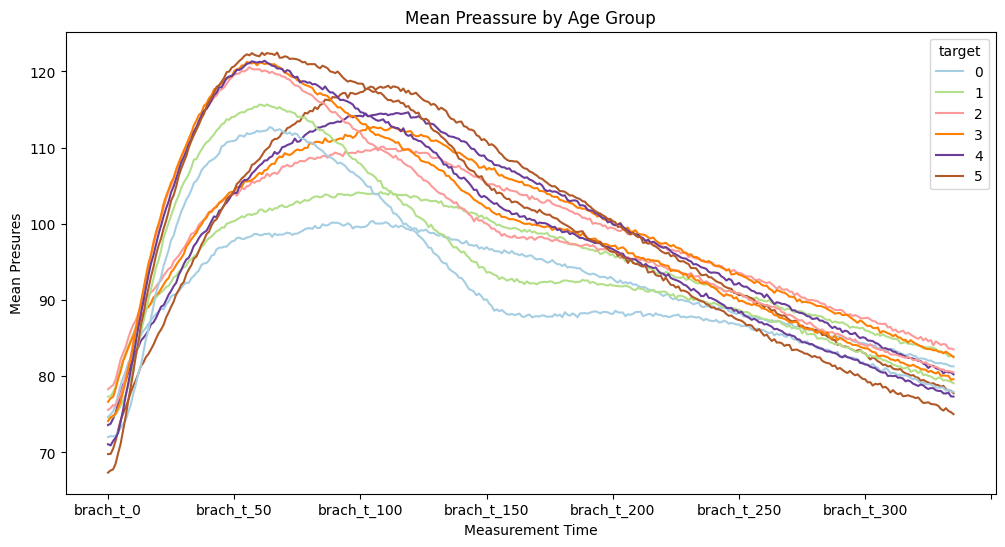

In [8]:
ax =A.groupby(['target']).mean().T.plot(title= 'Mean Preassure by Age Group', colormap='Paired',figsize=(12,6))
B.groupby(['target']).mean().T.plot(ax=ax, legend=False, colormap='Paired',figsize=(12,6))
ax.set_xlabel('Measurement Time')
ax.set_ylabel('Mean Presures')

Text(0, 0.5, 'Mean Presures')

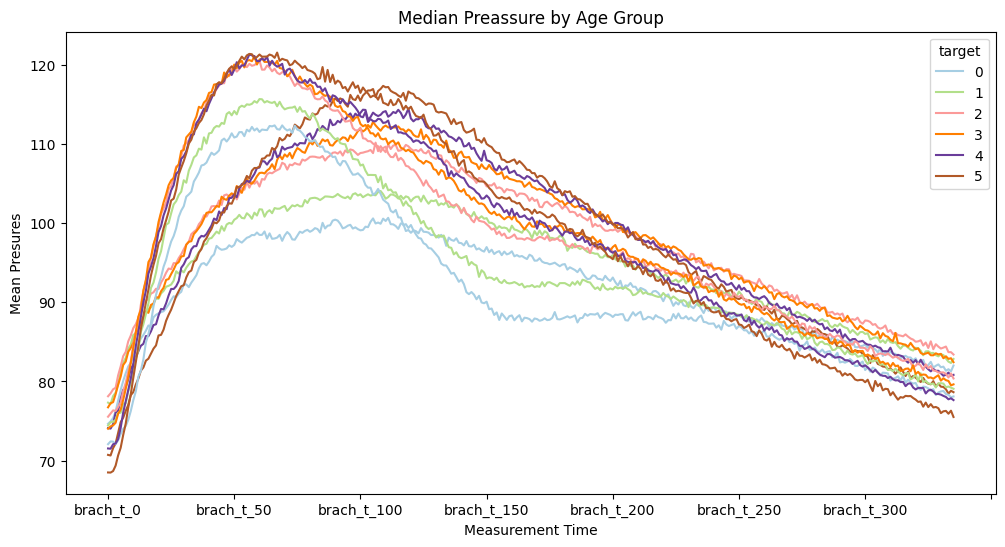

In [9]:
ax =A.groupby(['target']).median().T.plot(title= 'Median Preassure by Age Group', colormap='Paired',figsize=(12,6))
B.groupby(['target']).median().T.plot(ax=ax, legend=False, colormap='Paired',figsize=(12,6))
ax.set_xlabel('Measurement Time')
ax.set_ylabel('Mean Presures')

Text(0, 0.5, 'STD Presures')

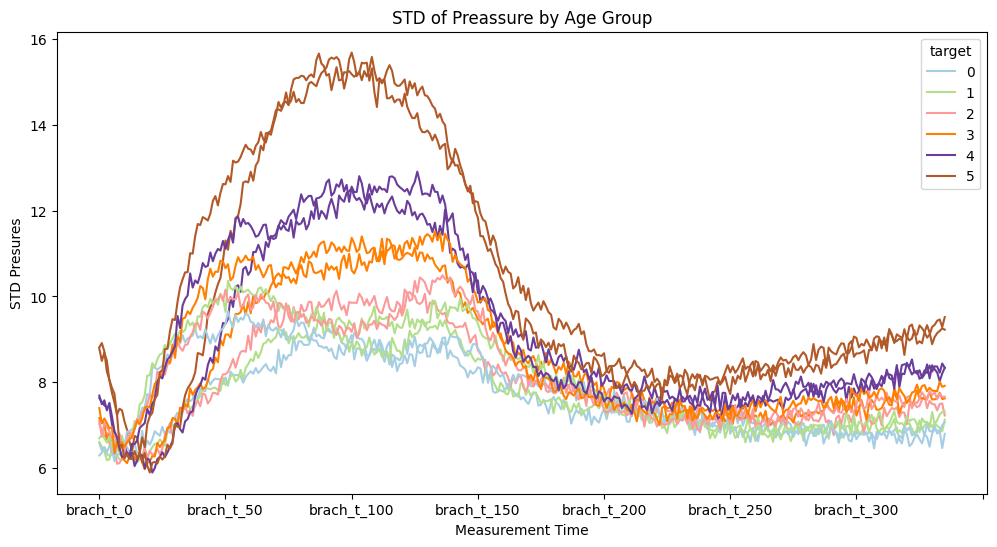

In [ ]:
ax =A.groupby(['target']).std().T.plot(title= 'STD of Preassure by Age Group', colormap='Paired',figsize=(12,6))
B.groupby(['target']).std().T.plot(ax=ax, legend=False, colormap='Paired',figsize=(12,6))
ax.set_xlabel('Measurement Time')
ax.set_ylabel('STD Presures')

# **4.0 Clean Data**

**4.1** Several imputation methods are applied to handling missing results.
>No approach is perfect; KNN Imputation seems good enough

In [10]:
#make imputed data sets via several methods
LPP_a,LPP_b   = linear_pulse_pair (A_x, B_x)
MPP_a,MPP_b   = mean_pulse_pair (A_x, B_x)
NDPP_a,NDPP_b = norm_dist_pulse_pair (A_x, B_x)
ANPP_a,ANPP_b = age_norm_dist_pulse_pair(A,B)

In [11]:
#impute using KNN technique
imputer_a = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer_b = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

imputer_a.fit(A_x)
A_x_knn = imputer_a.transform(A_x)
imputer_b.fit(B_x)
B_x_knn = imputer_b.transform(B_x)

In [12]:
#LOWESS smoothing of KNN imputed data
A_smooth=np.stack([sm_lowess(xi, np.arange(0,(len(xi))), is_sorted=True, frac=0.1, it=0, return_sorted=False) for xi in A_x_knn])
B_smooth=np.stack([sm_lowess(xi, np.arange(0,(len(xi))), is_sorted=True, frac=0.1, it=0, return_sorted=False) for xi in B_x_knn])

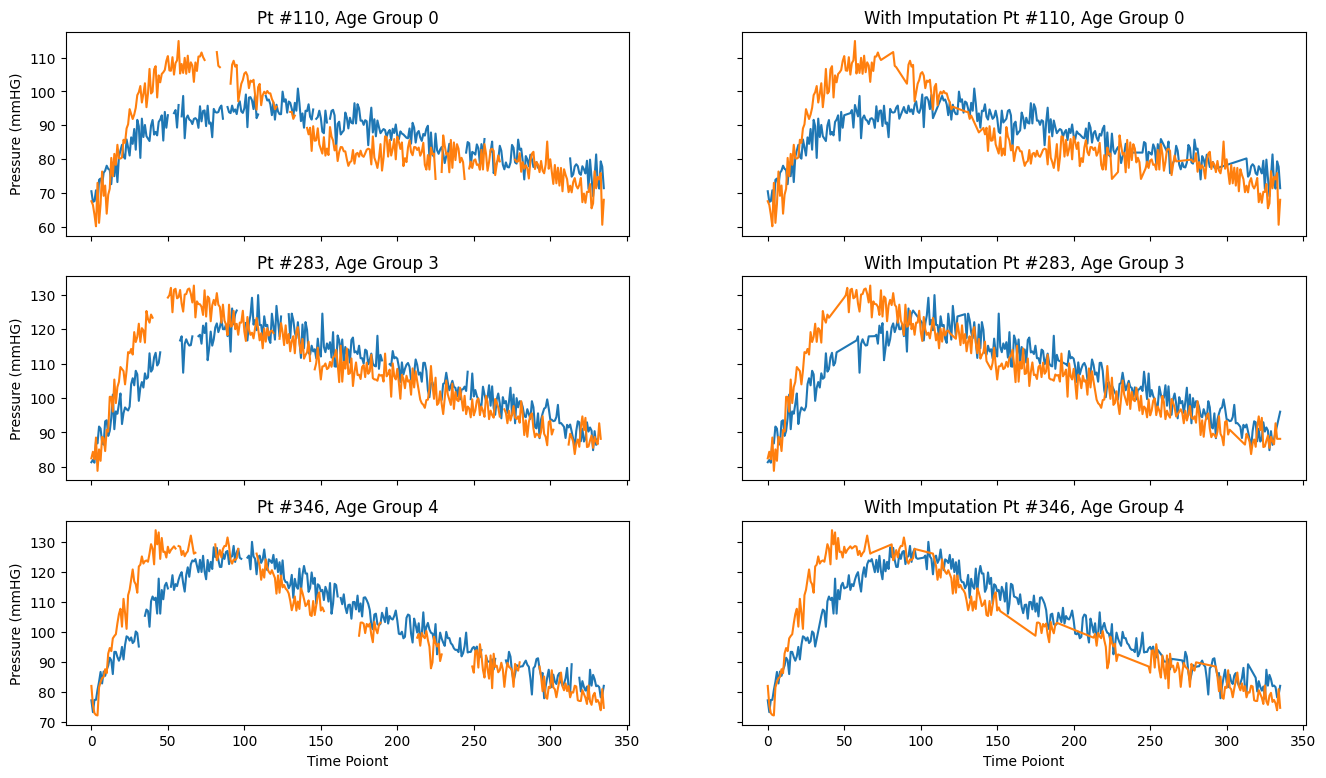

In [13]:
# plots of imputation using linear technique
plot_pts(A_x,B_x,LPP_a,LPP_b,A_y,3)

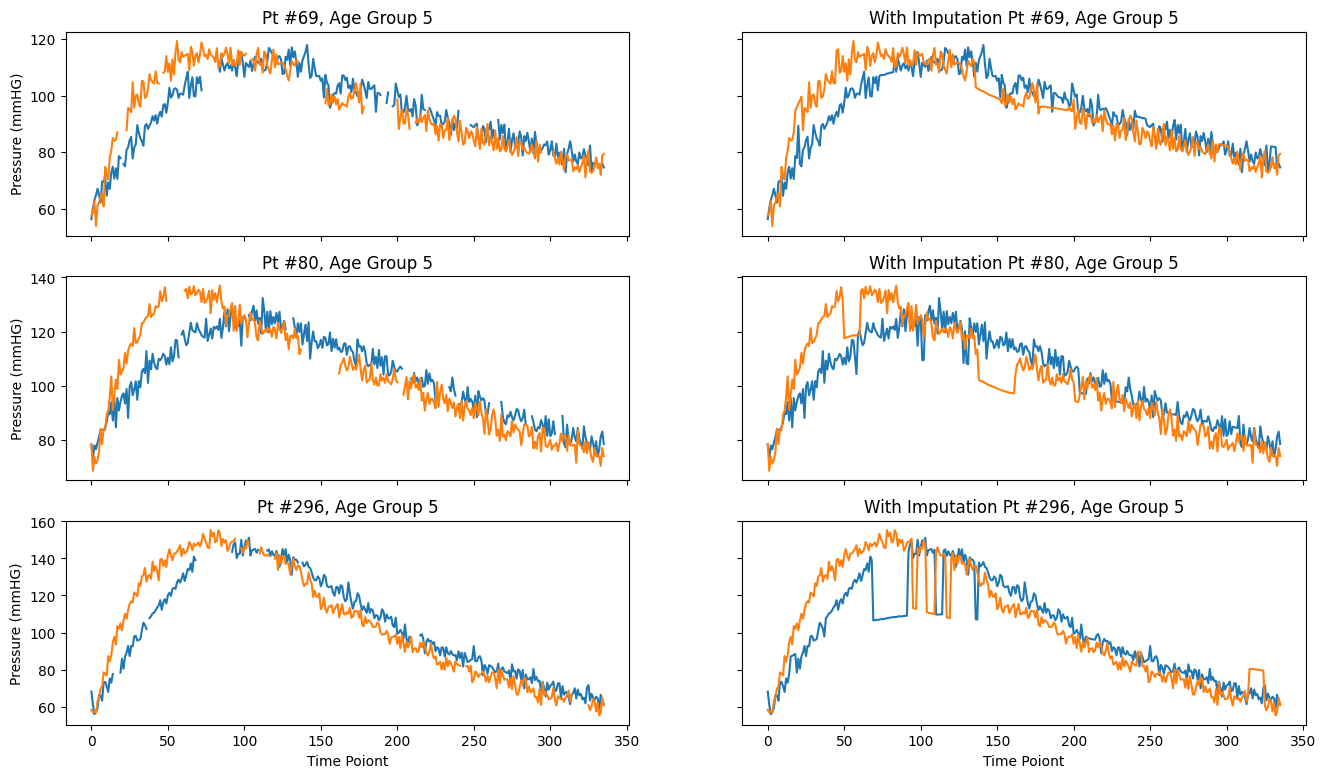

In [13]:
# plots using mean imputation
plot_pts(A_x,B_x,MPP_a,MPP_b,A_y,3)

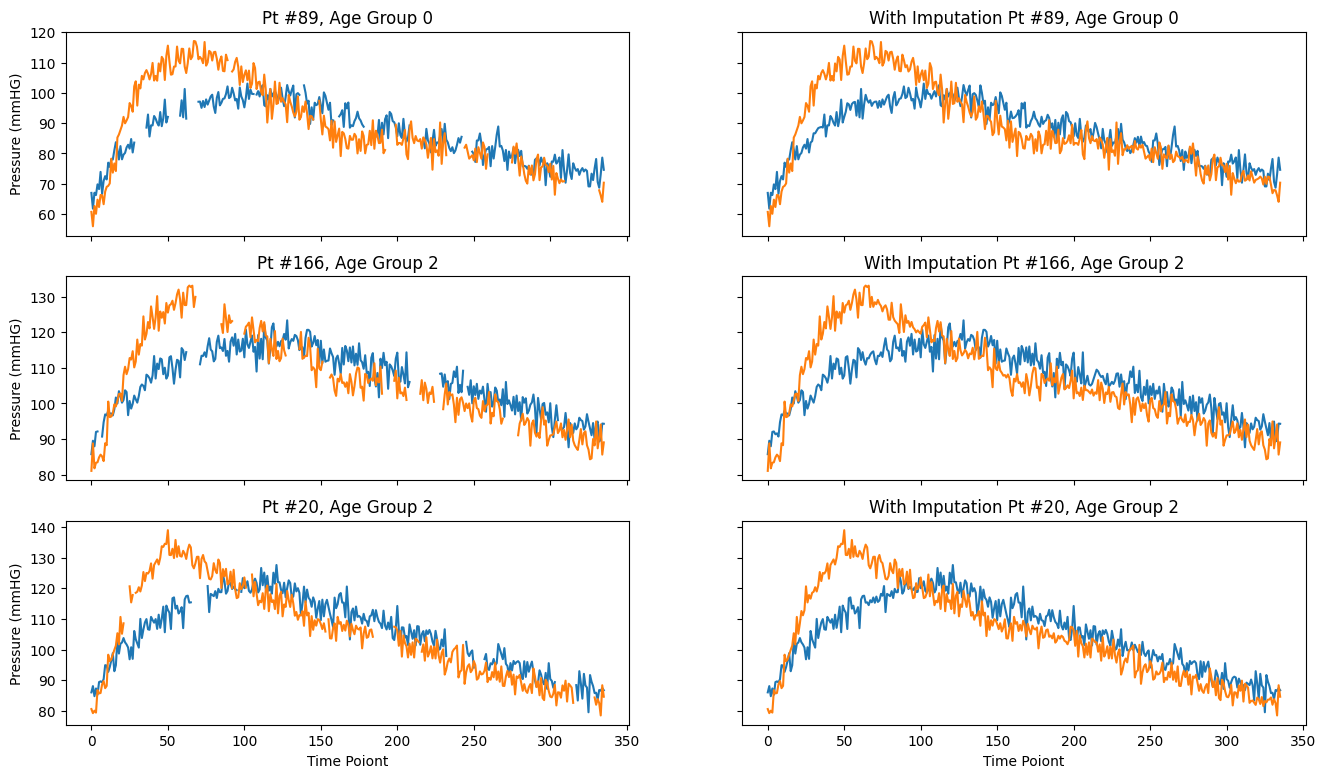

In [14]:
# plots using knn imputation
plot_pts(A_x,
         B_x,
         A_x_knn,
         B_x_knn,
         A_y,
         3)

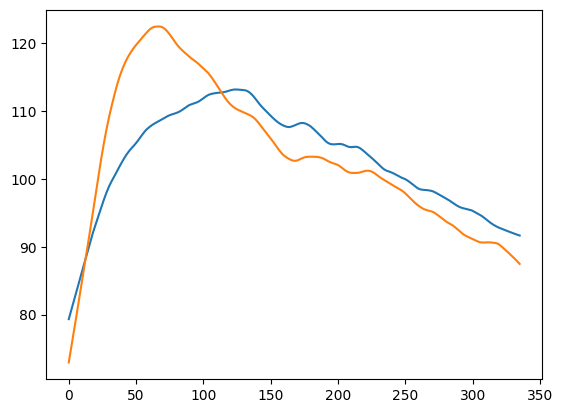

In [14]:
# quick plot of LOWESS smoothed data
plt.plot(A_smooth[1])
plt.plot(B_smooth[1])

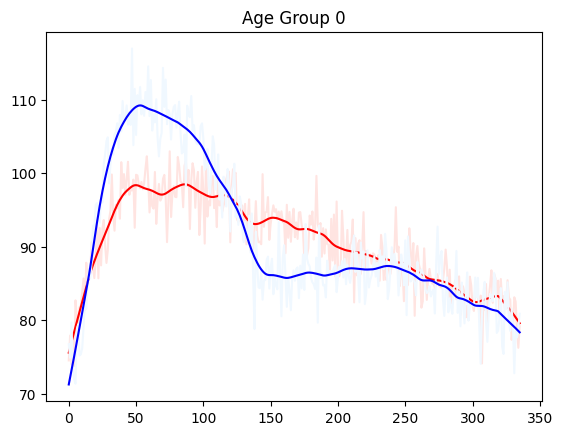

In [15]:
#plots a smoothed bet over KNN imputed beat
plot_smooth_beat(8)

# **5.1 Random Forest**
**5.1.1 Random Forest with A&B**

In [ ]:
X =np.hstack((LPP_a, LPP_b))
y = A_y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.40)

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7db98858c0d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7db988894dc0>})

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 18, 'n_estimators': 198}


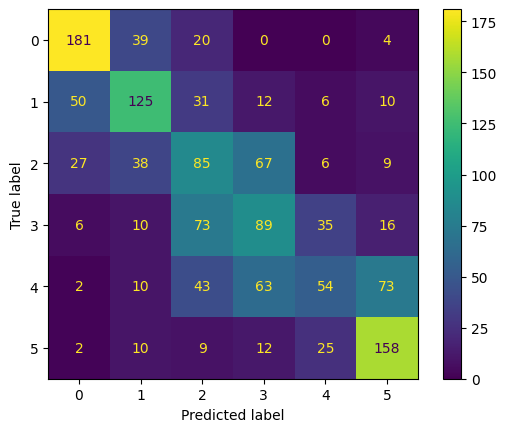

In [ ]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4942857142857143


**5.1.1b** Use the a feature vector with KNN imputed missing values

Best hyperparameters: {'max_depth': 17, 'n_estimators': 445}


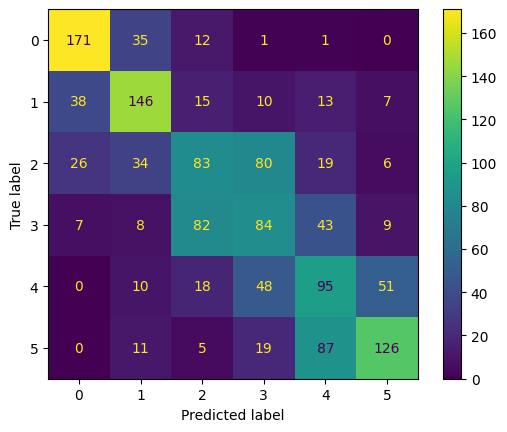

In [ ]:
X =np.hstack((A_x_knn, B_x_knn))
y = A_y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.40)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5035714285714286


5.1.2 Random Forest with Just Aortic data

In [ ]:
X =LPP_a
y = A_y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.40)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 277}


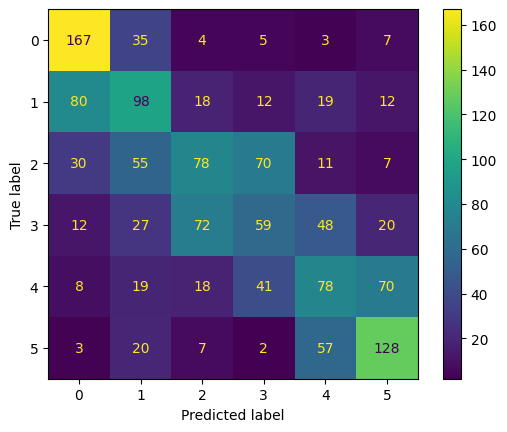

In [ ]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4342857142857143


# **5.2 CNN**
## **5.2.0** Preparation

In [155]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout

In [156]:
print(tf.__version__)

2.14.0


**KNN imputed data prep for CNN**

In [262]:
#Merge Aortic and Brachial signals into 2 chanel array
train_2chan = np.stack((A_x_knn, B_x_knn),axis=0)
train_2chan = np.moveaxis(train_2chan, 0,-1)

#normalize data using max_bp
max_bp=185
train_2chan = np.divide(train_2chan, max_bp)
print(f'Shape of Training Data is: {train_2chan.shape}')
print(f'Max normalized BP is: {train_2chan.max()}')
print(f'Min normalized BP is: {train_2chan.min()}')

#Make np array of targets/labels
darpa_labels = A_y.to_numpy()
one_hot_labels = tf.keras.utils.to_categorical(train_labels.astype('int64'),num_classes=6)
print(f'Shape of DARPA Labels is: {darpa_labels.shape}')
print(f'Shape of One Hot Labels is: {one_hot_labels.shape}')

Shape of Training Data is: (3499, 336, 2)
Max normalized BP is: 0.9416720701794166
Min normalized BP is: 0.2451499475656134
Shape of DARPA Labels is: (3499,)
Shape of One Hot Labels is: (3499, 6)


**SMOOTHED KNN imputed data prep for CNN**

In [89]:
"""#Merge Aortic and Brachial signals into 2 chanel array
train_2chan = np.stack((A_smooth, B_smooth),axis=0)
train_2chan = np.moveaxis(train_2chan, 0,-1)
print(f'Shape of Training Data is: {train_2chan.shape}')

#Make np array of targets/labels
train_labels = A_y.to_numpy()
one_hot_labels = tf.keras.utils.to_categorical(train_labels.astype('int64'),num_classes=6)
print(f'Shape of Training Labels is: {one_hot_labels.shape}')"""

Shape of Training Data is: (3499, 336, 2)
Shape of Training Labels is: (3499, 6)


In [263]:
from sklearn import model_selection

#Data Parameters
NUM_CLASSES = 6
suffle_size=3500

train_ratio =.70
validation_ratio=.15
test_ratio = .10

# Hyperparameters
random_seed = 1 # Not yet used
learning_rate = 0.05
batch_size = 128
num_epochs = 100

wave_train, wave_test, wave_train_labels, wave_test_labels = \
  model_selection.train_test_split(train_2chan,
                                   darpa_labels,
                                   test_size = 1 - train_ratio)

wave_val, wave_test, wave_val_labels, wave_test_labels = \
  model_selection.train_test_split(wave_test,
                                   wave_test_labels,
                                   test_size=test_ratio/(test_ratio + validation_ratio))


In [264]:
print("Shape of training images:", wave_train.shape)
print("Shape of training labels:", wave_train_labels.shape)

print("Shape of test images:", wave_test.shape)
print("Shape of test labels:", wave_test_labels.shape)

print("Shape of validation images:", wave_val.shape)
print("Shape of validation labels:", wave_val_labels.shape)

Shape of training images: (2449, 336, 2)
Shape of training labels: (2449,)
Shape of test images: (420, 336, 2)
Shape of test labels: (420,)
Shape of validation images: (630, 336, 2)
Shape of validation labels: (630,)


In [265]:
# Normalize 0-1 assuming a specificed max BP

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(wave_train, tf.float32),
   tf.cast(wave_train_labels, tf.int64)))
dataset = dataset.shuffle(suffle_size).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(wave_test, tf.float32),
   tf.cast(wave_test_labels, tf.int64)))
#test_dataset = test_dataset.shuffle(1000).batch(batch_size)
# Here we do not shuffle the test dataset.
test_dataset = test_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(wave_val, tf.float32),
   tf.cast(wave_val_labels, tf.int64)))
val_dataset = val_dataset.shuffle(suffle_size).batch(batch_size)


In [281]:
print("TRAINING DATA:")
for waves, target in dataset.as_numpy_iterator():
  print(f'The shape of one batch of train data: {waves.shape}')
  print(f'The first measurement of train: {waves[1][1]}')
  print(f'The corresponding target is: {target[1]}')
  print("\r")
  break

print("TESTING DATA:")
for waves, target in test_dataset.as_numpy_iterator():
  print(f'The shape of one batch of test data: {waves.shape}')
  print(f'The first measurement of test: {waves[1][1]}')
  print(f'The corresponding target is: {target[1]}')
  print('NOTE: Testing Data is NOT shuffled each call')
  print("\r")
  break

print("VALIDATION DATA:")
for waves, target in val_dataset.as_numpy_iterator():
  print(f'The shape of one batch of val data: {waves.shape}')
  print(f'The first measurement of val: {waves[1][1]}')
  print(f'The corresponding target is: {target[1]}')
  break


TRAINING DATA:
The shape of one batch of train data: (128, 336, 2)
The first measurement of train: [0.41754544 0.41555604]
The corresponding target is: 0

TESTING DATA:
The shape of one batch of test data: (128, 336, 2)
The first measurement of test: [0.46250707 0.4345742 ]
The corresponding target is: 1
NOTE: Testing Data is NOT shuffled each call

VALIDATION DATA:
The shape of one batch of val data: (128, 336, 2)
The first measurement of val: [0.4875216  0.47615916]
The corresponding target is: 3


In [306]:
def create_model(num_classes):
  model = Sequential()
  model.add(Conv1D(32, 4, activation='relu', input_shape = (336,2)))
  model.add(Flatten())
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.1))
  # Ordinal output layer with a certain number of classes / ranks / labels.
  # No activation function specified so this will output cumulative logits.
  model.add(coral.CoralOrdinal(num_classes))
  return model

model = create_model(NUM_CLASSES)

# Note that the model generates 1 fewer outputs than the number of classes.
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 333, 32)           288       
                                                                 
 flatten_16 (Flatten)        (None, 10656)             0         
                                                                 
 dense_42 (Dense)            (None, 128)               1364096   
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 32)                4128      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 coral_ordinal_5 (CoralOrdi  (None, 5)               

In [307]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss = coral.OrdinalCrossEntropy(num_classes = NUM_CLASSES),
              metrics = [coral.MeanAbsoluteErrorLabels()])

In [312]:
%%time

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stop = tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

# This takes about 5 minutes on CPU, 2.5 minutes on GPU.
history = model.fit(dataset, epochs = 100, validation_data = val_dataset,
                    callbacks = [[tensorboard_callback, early_stop]])

Epoch 1/100
20/20 [==============================] - 0s 13ms/step - loss: 2.8838 - mean_absolute_error_labels: 1.4979 - val_loss: 2.8421 - val_mean_absolute_error_labels: 1.4887
Epoch 2/100
20/20 [==============================] - 0s 12ms/step - loss: 2.8836 - mean_absolute_error_labels: 1.4983 - val_loss: 2.8401 - val_mean_absolute_error_labels: 1.4867
Epoch 3/100
20/20 [==============================] - 0s 13ms/step - loss: 2.8849 - mean_absolute_error_labels: 1.5157 - val_loss: 2.8399 - val_mean_absolute_error_labels: 1.4888
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 2.8846 - mean_absolute_error_labels: 1.5009 - val_loss: 2.8427 - val_mean_absolute_error_labels: 1.4863
Epoch 5/100
20/20 [==============================] - 0s 19ms/step - loss: 2.8842 - mean_absolute_error_labels: 1.5009 - val_loss: 2.8406 - val_mean_absolute_error_labels: 1.4874
Epoch 6/100
20/20 [==============================] - 0s 14ms/step - loss: 2.8838 - mean_absolute_error_labels:

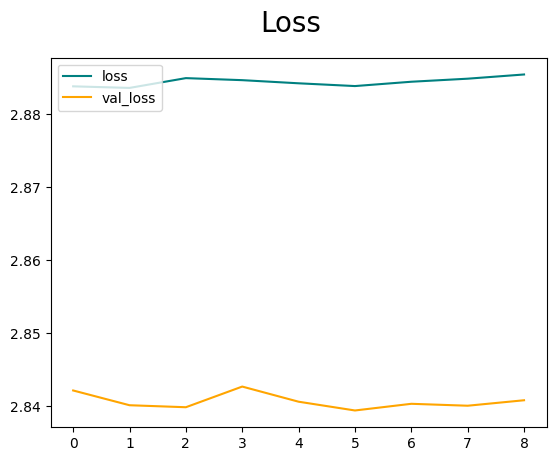

In [315]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [318]:
history.history

{'loss': [2.883779525756836,
  2.883563280105591,
  2.884904146194458,
  2.884624481201172,
  2.884195327758789,
  2.8838162422180176,
  2.884409189224243,
  2.884826421737671,
  2.8854029178619385],
 'mean_absolute_error_labels': [1.4979089498519897,
  1.498322606086731,
  1.5157169103622437,
  1.5008732080459595,
  1.5008732080459595,
  1.5106388330459595,
  1.5284696817398071,
  1.519646167755127,
  1.5157629251480103],
 'val_loss': [2.8421471118927,
  2.8401260375976562,
  2.8398523330688477,
  2.8426804542541504,
  2.8406083583831787,
  2.8394081592559814,
  2.8403220176696777,
  2.840059280395508,
  2.8408074378967285],
 'val_mean_absolute_error_labels': [1.4886916875839233,
  1.4867055416107178,
  1.4888241291046143,
  1.4863083362579346,
  1.4873676300048828,
  1.467160940170288,
  1.4859110116958618,
  1.4706038236618042,
  1.4849841594696045]}

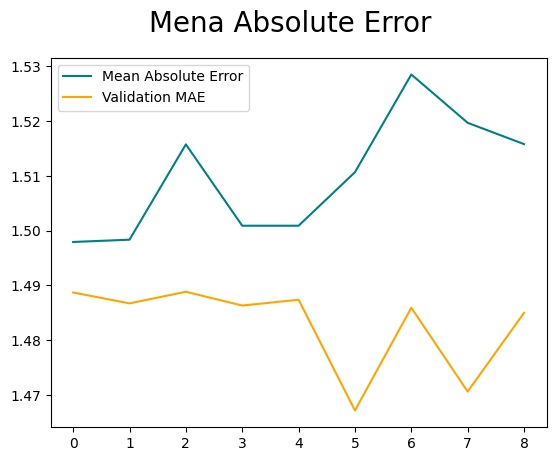

In [321]:
fig = plt.figure()
plt.plot(history.history['mean_absolute_error_labels'], color='teal', label='Mean Absolute Error')
plt.plot(history.history['val_mean_absolute_error_labels'], color='orange', label='Validation MAE')
fig.suptitle('Mena Absolute Error', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [313]:
# Evaluate on test dataset.
model.evaluate(test_dataset)

4/4 [==============================] - 0s 16ms/step - loss: 2.8020 - mean_absolute_error_labels: 1.4015


[2.801971673965454, 1.4014756679534912]

In [314]:
import pandas as pd

print("Predict on test dataset")

# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
ordinal_logits = model.predict(test_dataset)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
tensor_probs = coral.ordinal_softmax(ordinal_logits)

# Convert the tensor into a pandas dataframe.
probs_df = pd.DataFrame(tensor_probs.numpy())

probs_df.head()

Predict on test dataset
4/4 [==============================] - 0s 3ms/step


,0,1,2,3,4,5
0,0.168145,0.169531,0.162104,0.16771,0.163325,0.169185
1,0.168145,0.169531,0.162104,0.16771,0.163325,0.169185
2,0.168145,0.169531,0.162104,0.16771,0.163325,0.169185
3,0.168145,0.169531,0.162104,0.16771,0.163325,0.169185
4,0.168145,0.169531,0.162104,0.16771,0.163325,0.169185


**TO DO**:
1. **normalize_bp**: function that normalizes pressure by dividing by 185 (max is 174). Does not consider cases of BP>185

2. **partion_prep_tf_data**: creates data pipeline and splits into training, validation, and test partitions




In [158]:
def normalize_bp(signal, target):
  max_bp =185
  return (signal / max_bp, target)

def partion_prep_tf_data(bp_data, size,
                         train_split=0.6, val_split=0.2, test_split=0.2,
                         shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        bp_data = bp_data.shuffle(shuffle_size, seed=12)
    bp_data= bp_data.map(normalize_bp,
                         num_parallel_calls=tf.data.AUTOTUNE)
    bp_data= bp_data.cache()

    train_size = int(train_split * size)
    val_size = int(val_split * size)

    train_bp = bp_data.take(train_size)
    train_bp = train_bp.batch(64)

    val_bp = bp_data.skip(train_size).take(val_size)
    val_bp = val_bp.batch(64)

    test_bp = bp_data.skip(train_size).skip(val_size)
    test_bp = test_bp.batch(64)

    return train_bp, val_bp, test_bp

In [170]:
#creates tensorflow dataset
bp_data= tf.data.Dataset.from_tensor_slices((train_2chan,
                                             train_labels))
# normalizes data, splits and batches data
train, val, test = partion_prep_tf_data(bp_data,len(bp_data), shuffle_size=len(bp_data) )

In [171]:
#check the number of batches (each batch is 64 patients)
print(f'Number of train batches: {len(train)}')
print(f'Number of val batches: {len(val)}')
print(f'Number of test batches: {len(test)}')

#spot check train data produced by tf pipeline
for waves, target in train.as_numpy_iterator():
  print(f'The shape of one batch of data: {waves.shape}')
  print(f'The first measurement of train: {waves[1][1]}')
  print(f'The corresponding one-hot encoded target is: {target[1]}')
  break

Number of train batches: 33
Number of val batches: 11
Number of test batches: 11
The shape of one batch of data: (64, 336, 2)
The first measurement of train: [0.40790719 0.37741414]
The corresponding one-hot encoded target is: 2


In [161]:
!pip install --force-reinstall --no-deps git+https://github.com/ck37/coral-ordinal/

  Cloning https://github.com/ck37/coral-ordinal/ to /tmp/pip-req-build-a6796ouq
  Running command git clone --filter=blob:none --quiet https://github.com/ck37/coral-ordinal/ /tmp/pip-req-build-a6796ouq
  Resolved https://github.com/ck37/coral-ordinal/ to commit e42038b66705bcd6fb52152cf28ce8278a16912c
  Preparing metadata (setup.py) ... done
  Created wheel for coral-ordinal: filename=coral_ordinal-0.1.9.dev0-py3-none-any.whl size=14592 sha256=d7ec76fc6197cd7eb444f5f7fa922fffb86a2913542d5fa0ec12bc0196f4e5f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-rgrx330h/wheels/85/68/e8/f57f5696d75898becfbda71caf87c581d3a44fa4a2280cd45b
Successfully built coral-ordinal


In [162]:
import tensorflow as tf
print("Tensorflow version", tf.__version__)

import coral_ordinal as coral
print("CORAL Ordinal version:", coral.__version__)

Tensorflow version 2.14.0
CORAL Ordinal version: 0.1.9.dev


In [51]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=8, activation="relu", input_shape=(336,2)))

model.add(Dense(128, activation='relu'))
#model.add(Conv1D(filters=16, kernel_size=8, activation="relu"))
#model.add(Conv1D(filters=32, kernel_size=8, activation="relu"))
#model.add(MaxPooling1D())
#model.add(Dropout(.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer = "adam",
              metrics = ['CategoricalAccuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 329, 32)           544       
                                                                 
 dense_25 (Dense)            (None, 329, 128)          4224      
                                                                 
 flatten_12 (Flatten)        (None, 42112)             0         
                                                                 
 dense_26 (Dense)            (None, 128)               5390464   
                                                                 
 dense_27 (Dense)            (None, 6)                 774       
                                                                 
Total params: 5396006 (20.58 MB)
Trainable params: 5396006 (20.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [309]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

hist = model.fit(train,
                 epochs=1000,
                 validation_data=val,
                 callbacks=[tensorboard_callback, early_stop])

Epoch 1/1000
33/33 [==============================] - 1s 16ms/step - loss: 2.8553 - mean_absolute_error_labels: 1.4973 - val_loss: 2.8750 - val_mean_absolute_error_labels: 1.5015
Epoch 2/1000
33/33 [==============================] - 0s 11ms/step - loss: 2.8692 - mean_absolute_error_labels: 1.5310 - val_loss: 2.8787 - val_mean_absolute_error_labels: 1.4876
Epoch 3/1000
33/33 [==============================] - 0s 10ms/step - loss: 2.8886 - mean_absolute_error_labels: 1.5111 - val_loss: 2.8537 - val_mean_absolute_error_labels: 1.4685
Epoch 4/1000
33/33 [==============================] - 0s 10ms/step - loss: 2.8967 - mean_absolute_error_labels: 1.5203 - val_loss: 2.8674 - val_mean_absolute_error_labels: 1.4904
Epoch 5/1000
33/33 [==============================] - 0s 9ms/step - loss: 2.8636 - mean_absolute_error_labels: 1.4867 - val_loss: 2.8346 - val_mean_absolute_error_labels: 1.4739
Epoch 6/1000
33/33 [==============================] - 0s 12ms/step - loss: 2.8781 - mean_absolute_error_la

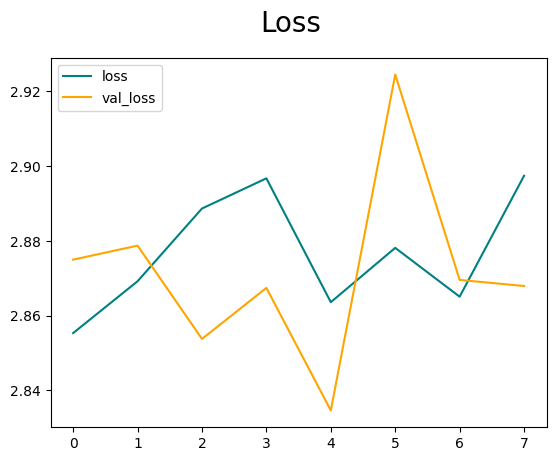

In [310]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [311]:
fig = plt.figure()
plt.plot(hist.history['categorical_accuracy'], color='teal', label='Categorical Accuracy')
plt.plot(hist.history['val_categorical_accuracy'], color='orange', label='Validation Categorical Accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


KeyboardInterrupt



<Figure size 640x480 with 0 Axes>

In [79]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()


In [80]:
pred_target=[]
target=[]
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat=model.predict(X)
    pred_target.append(yhat)
    target.append(y)

    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2/2 [==============================] - 0s 78ms/step


In [81]:
print(pre.result())
print(re.result())
print(acc.result())

tf.Tensor(0.61918604, shape=(), dtype=float32)
tf.Tensor(0.30385163, shape=(), dtype=float32)
tf.Tensor(0.46932954, shape=(), dtype=float32)


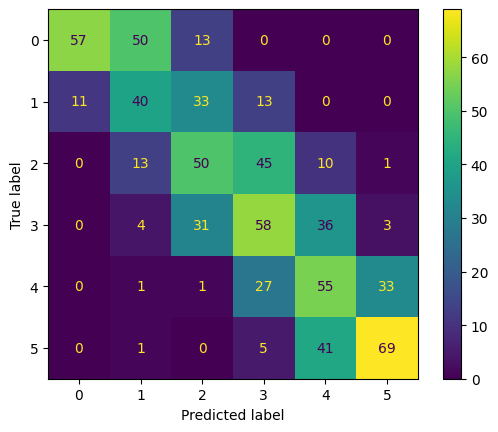

In [82]:
cm = confusion_matrix(np.argmax(np.vstack(target), axis=1),
                          np.argmax(np.vstack(pred_target), axis=1) )
ConfusionMatrixDisplay(confusion_matrix=cm).plot();


# **6.0 Process Final Holdout Data**

## **6.1 Import Test CSV files**

In [137]:
#Import List of Testing Files
test_folder = '1XmDWuNAni2tZuEYxfEUEFPaVyOhlw3kL'
file_list = list_csv_files(test_folder)
df_dict = download_and_read_csv(file_list)

#create brachial testing df
brachial_df= df_dict['brachP_test_data.csv']
#drop column prefixes
#brachial_TR_df.columns = brachial_TR_df.columns.str.replace('brach_t_','',regex=True)

#create aortic testing df
aortic_df= df_dict['aortaP_test_data.csv']
#drop column prefixes
#aortic_TR_df.columns = aortic_TR_df.columns.str.replace('aorta_t_','',regex=True)

#Aortic Training Data and Labels
A_test   = df_dict['aortaP_test_data.csv']
#A_x = df_dict['aortaP_test_data.csv'].drop('target', axis=1)
#A_y = df_dict['aortaP_test_data.csv']['target']
#Brachial Training Data and Labels
B_test   = df_dict['brachP_test_data.csv']
#B_x = df_dict['brachP_test_data.csv'].drop('target',axis=1)
#B_y = df_dict['brachP_test_data.csv']['target']

Title:  brachP_test_data.csv , ID:  1MIPPPvFLWHPsJnIIdnZ5ReBWjGD2fWtp
Title:  aortaP_test_data.csv , ID:  1MFT6xsBZ_WY-A5eoRfCKX8CMqAWojACF


In [138]:
print (f'The Shape of Aortic data is: {A.shape}')
print (f'The Shape of Brachial data is: {B.shape}')

The Shape of Aortic data is: (875, 336)
The Shape of Brachial data is: (875, 336)


In [140]:
print(f'Aortic Values (mean number of missing values per pt): {A.isna().sum(1).mean()}')
print(f'Brachial Values (mean number of missing values per pt): {B.isna().sum(1).mean()}')

Aortic Values (mean number of missing values per pt): 41.12228571428572
Brachial Values (mean number of missing values per pt): 42.075428571428574


## **6.2 Impute missing data using KNN**

In [141]:
#impute using KNN technique
imputer_a = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer_b = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

imputer_a.fit(A_test)
A_test_knn = imputer_a.transform(A_test)
imputer_b.fit(B_test)
B_test_knn = imputer_b.transform(B_test)

In [142]:
print(f' A_test_knn shape: {A_test_knn.shape}')
print(f' B_test_knn shape: {B_test_knn.shape}')

 A_test_knn shape: (875, 336)
 B_test_knn shape: (875, 336)


In [144]:
#Merge Aortic and Brachial signals into 2 chanel array
test_2chan = np.stack((A_test_knn, B_test_knn),axis=0)
test_2chan = np.moveaxis(test_2chan, 0,-1)
print(f'Shape of Training Data is: {test_2chan.shape}')
print(f'Max BP is: {np.max(test_2chan)}')
print(f'Min BP is: {np.min(test_2chan)}')

Shape of Training Data is: (875, 336, 2)
Max BP is: 166.95469543797634
Min BP is: 43.396634015284114


In [145]:
#normalize BP
max_bp = 185
test_2chan= test_2chan/max_bp
print(f'Shape of Training Data is: {test_2chan.shape}')
print(f'Max BP is: {np.max(test_2chan)}')
print(f'Min Bp is: {np.min(test_2chan)}')

Shape of Training Data is: (875, 336, 2)
Max BP is: 0.9024578131782505
Min Bp is: 0.23457640008261682


In [146]:
#creates tensor flow dataset
bp_test_data= tf.data.Dataset.from_tensor_slices(test_2chan)
#batch into grooups of 64pts
bp_test_data= bp_test_data.batch(64)

In [147]:
#Check the shape of a data batch
for signal in bp_test_data.as_numpy_iterator():
  print(signal.shape)
  break

(64, 336, 2)


## **6.3 Make Predictions and Write to JSON**

In [151]:
test_predictions= model.predict(bp_test_data)
#convert one-hot to integer value
test_predictions= np.argmax(test_predictions, axis=1)
#convert np.array to dictionary
test_dict= dict(enumerate(test_predictions))

14/14 [==============================] - 0s 4ms/step


## **6.4 Write to JSON**
Write predictions to JSON File

**NOTE**: Readme document specifies that JSON Key:Value pair both be integers even though JSON standard expects Keys to be in string format.

In [154]:
#Write out to JSON file
team_name= "TaskForce3"
with open(f'{team_name}_output.json', 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(test_dict, f, default=int, indent=2,)

# **Appendix**
- saved figs and code

<Axes: >

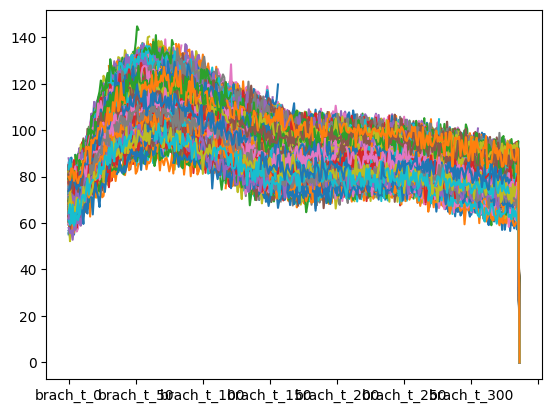

In [83]:
brachial_TR_df[brachial_TR_df['target']==0].T.plot(legend=None)

<Axes: >

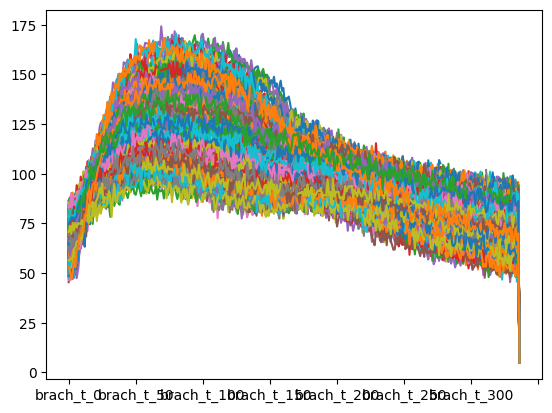

In [84]:
brachial_TR_df[brachial_TR_df['target']==5].T.plot(legend=None)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


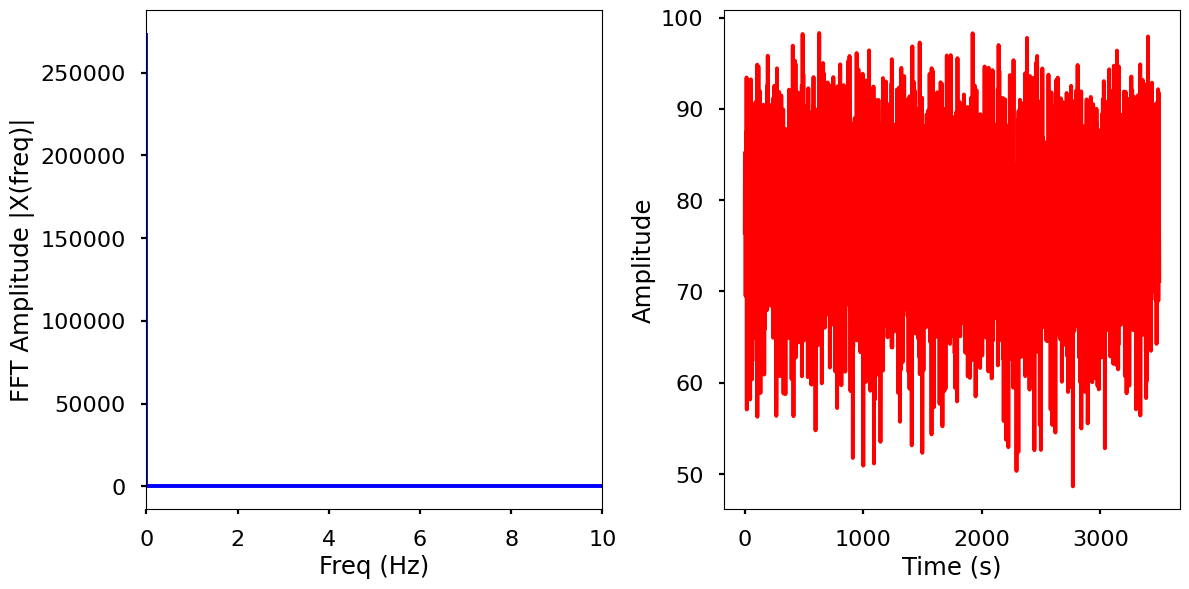

In [ ]:
from numpy.fft import fft, ifft
x=np.array(brachial_T.iloc[335].interpolate('linear'))

# sampling rate
sr = 500
# sampling interval
ts = 1.0/sr
t = np.arange(0,len(brachial_T.iloc[335]))

X = fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [ ]:
# Identify unique prefixes
aortic_brachial_delta_df=aortic_TR_df.drop(columns=['target']).subtract(brachial_TR_df.drop(columns=['target'])).join(aortic_TR_df['target'])